# Creating a training dataset

This notebook creates a dataset of passes and generates features and labels.

In [2]:
from pathlib import Path

import pandas as pd
import tqdm
pd.set_option('display.max_columns', None)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os, sys

sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

In [5]:
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset

/home/toc3/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Configure folder names

First, we define were the processed data should be stored.

In [11]:
DATA_DIR = Path("../stores/")

## Create database connection

We need a database with StatsBomb 360 data to extract passes from.

In [13]:
test_DB_PATH = Path("../stores/test-database.sqlite")
test_db = SQLiteDatabase(test_DB_PATH)

### 모든 경기의 game_id 저장하기

In [23]:
from statsbombpy import sb
from socceraction.data.statsbomb import StatsBombLoader

SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

#StatsBomb360데이터에서는 3종류의 데이터만 지원함(2022월드컵, 20남자 유에파, 22여자 유에파)
competition = sb.competitions()
competition = competition[(competition.competition_id == 43) & (competition.season_id == 106) |
            (competition.competition_id == 55) & (competition.season_id == 43) |
            (competition.competition_id == 53) & (competition.season_id == 106)]

/home/toc3/anaconda3/lib/python3.7/site-packages/statsbombpy/api_client.py:22: NoAuthWarning: credentials were not supplied. open data access only
  "credentials were not supplied. open data access only", NoAuthWarning


In [24]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in competition.itertuples()
])

games = games.reset_index().drop(columns='index')
games

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,3857256,106,43,Group Stage,3,2022-12-02 21:00:00,786,773,2,3,Stadium 974,Fernando Andrés Rapallini
1,3869151,106,43,Round of 16,4,2022-12-03 21:00:00,779,792,2,1,Ahmad bin Ali Stadium,Szymon Marciniak
2,3857257,106,43,Group Stage,3,2022-11-30 17:00:00,792,776,1,0,Al Janoub Stadium,Mustapha Ghorbal
3,3857258,106,43,Group Stage,1,2022-11-24 21:00:00,781,786,2,0,Lusail Stadium,Alireza Faghani
4,3857288,106,43,Group Stage,2,2022-11-26 12:00:00,777,792,0,1,Al Janoub Stadium,Daniel Siebert
...,...,...,...,...,...,...,...,...,...,...,...,...
141,3835334,106,53,Group Stage,2,2022-07-14 18:00:00,855,862,1,1,Academy Stadium,Lina Lehtovaara
142,3835328,106,53,Group Stage,2,2022-07-11 18:00:00,859,2457,2,0,St. Mary''s Stadium,Emikar Caldera Barrera
143,3835333,106,53,Group Stage,2,2022-07-14 21:00:00,861,854,2,1,AESSEAL New York Stadium,Cheryl Foster
144,3835321,106,53,Group Stage,1,2022-07-08 18:00:00,863,920,4,1,Stadium MK,Kateryna Monzul


In [147]:
import socceraction.spadl as spadl
games_verbose = tqdm.tqdm(list(games[games['game_id'] == 3795107].itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}

for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

datafolder = "./data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = competition
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]
        
example_df = pd.DataFrame()
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    #Select korea vs germany game at World Cup
    game = games
    
    for i in range(len(game.game_id)):
        game_id = game.game_id.values[i]
    
        try : 
            actions = (spadlstore[f"actions/game_{game_id}"]
                .merge(spadl.actiontypes_df(), how="left")
                .merge(spadl.results_df(), how="left")
                .merge(spadl.bodyparts_df(), how="left")
                .merge(spadlstore["players"], how="left")
                .merge(spadlstore["teams"], how="left")
                )
            actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
            del actions['nickname']
        
            example_df = pd.concat([example_df,actions],axis=0)  
        except:
            print(end="")
           

Loading game data: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
/home/toc3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['competition_stage', 'venue', 'referee', 'country_name',
       'competition_name', 'competition_gender', 'season_name',
       'match_updated', 'match_updated_360', 'match_available_360',
       'match_available', 'home_team_name', 'away_team_name'],
      dtype='object')]

  exec(code_obj, self.user_global_ns, self.user_ns)
/home/toc3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['player_name', 'nickname'], dtype='object')]

  exec(code_obj, self

In [148]:
example_df

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,3795107,cac7b0b7-e051-4266-874a-37d5185c8a4e,1,1.0,782,3289.0,52.058824,34.430380,46.941176,37.615190,0,1,5,0,pass,success,foot_right,Romelu Lukaku,Belgium
1,3795107,5c1ef827-e053-44f8-a0f0-b312a3ca093d,1,1.0,782,5642.0,46.941176,37.615190,44.470588,39.853165,21,1,0,1,dribble,success,foot,Axel Witsel,Belgium
2,3795107,ba26ec0b-3274-481c-90d1-c58bd71bc81f,1,2.0,782,5642.0,44.470588,39.853165,29.205882,53.797468,0,1,5,2,pass,success,foot_right,Axel Witsel,Belgium
3,3795107,1783a21c-bb70-4353-bed4-5883f66a1f68,1,4.0,782,3077.0,29.205882,53.797468,28.235294,56.207595,21,1,0,3,dribble,success,foot,Jan Vertonghen,Belgium
4,3795107,f8b6772a-4272-4aa1-8eda-184d2a8248a8,1,6.0,782,3077.0,28.235294,56.207595,35.382353,67.483544,0,1,4,4,pass,success,foot_left,Jan Vertonghen,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198,3795107,91c6f928-680e-4f83-a003-4889a177efe8,2,3074.0,782,5632.0,101.029412,16.612658,101.294118,16.612658,21,1,0,2198,dribble,success,foot,Thorgan Hazard,Belgium
2199,3795107,6688f547-a021-41b1-a454-91ec7255c970,2,3074.0,782,5632.0,101.294118,16.612658,99.264706,27.372152,1,0,5,2199,cross,fail,foot_right,Thorgan Hazard,Belgium
2200,3795107,06d05275-9d28-41bf-8812-976814b2ec59,2,3074.0,914,6954.0,100.058824,26.597468,105.000000,0.000000,18,1,1,2200,clearance,success,head,Giorgio Chiellini,Italy
2201,3795107,864e6afd-6772-4d61-875d-995d52ffc18a,2,3092.0,782,5630.0,105.000000,0.000000,99.529412,24.617722,5,1,5,2201,corner_crossed,success,foot_right,Dries Mertens,Belgium


In [94]:
games.reset_index()

,index,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
0,0,3857256,106,43,Group Stage,3,2022-12-02 21:00:00,786,773,2,3,Stadium 974,Fernando Andrés Rapallini
1,1,3869151,106,43,Round of 16,4,2022-12-03 21:00:00,779,792,2,1,Ahmad bin Ali Stadium,Szymon Marciniak
2,2,3857257,106,43,Group Stage,3,2022-11-30 17:00:00,792,776,1,0,Al Janoub Stadium,Mustapha Ghorbal
3,3,3857258,106,43,Group Stage,1,2022-11-24 21:00:00,781,786,2,0,Lusail Stadium,Alireza Faghani
4,4,3857288,106,43,Group Stage,2,2022-11-26 12:00:00,777,792,0,1,Al Janoub Stadium,Daniel Siebert
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,141,3835334,106,53,Group Stage,2,2022-07-14 18:00:00,855,862,1,1,Academy Stadium,Lina Lehtovaara
142,142,3835328,106,53,Group Stage,2,2022-07-11 18:00:00,859,2457,2,0,St. Mary''s Stadium,Emikar Caldera Barrera
143,143,3835333,106,53,Group Stage,2,2022-07-14 21:00:00,861,854,2,1,AESSEAL New York Stadium,Cheryl Foster
144,144,3835321,106,53,Group Stage,1,2022-07-08 18:00:00,863,920,4,1,Stadium MK,Kateryna Monzul


### game_id에 해당하는 경기를 불러오기

In [95]:
games[['season_id','competition_id']].value_counts()

season_id  competition_id
106        43                64
43         55                51
106        53                31
dtype: int64

In [26]:
games.game_id

0      3857256
1      3869151
2      3857257
3      3857258
4      3857288
        ...   
141    3835334
142    3835328
143    3835333
144    3835321
145    3835319
Name: game_id, Length: 146, dtype: int64

In [28]:
from socceraction.spadl.utils import add_names

game_id = 3869254

# load SPADL actions
df_actions = add_names(test_db.actions(game_id))
df_actions.head()

original_event_id  period_id  \
game_id action_id                                                    
3869254 0          1827e54b-4067-4927-8051-60dc9fdccc0c          1   
        1          d003e9db-5abd-4a20-a607-e7493570bf65          1   
        2          9f7e5e78-b54f-4258-91c2-086e19cbf3f7          1   
        3          e7ca6924-132e-4374-877d-9f3e9acbe79f          1   
        4          9ef8364e-ff77-47db-9299-8a1af20d8da2          1   

                   time_seconds  team_id  player_id    start_x    start_y  \
game_id action_id                                                           
3869254 0                   0.0      773       5545  52.941176  33.569620   
        1                   2.0      773       5549  75.000000  46.997468   
        2                   4.0      773       5549  75.176471  47.858228   
        3                   7.0      780      16028  34.500000  23.584810   
        4                   9.0      773       5544  49.852941  17.559494   

                       end_x      end_y  bodypart_id  type_id  result_id  \
game_id action_id                                                          
3869254 0          75.000000  46.997468            5        0          1   
        1          75.176471  47.858228            0       21          1   
        2          35.294118  22.810127            5        0          0   
        3          49.852941  17.559494            1       18          1   
        4          39.264706  20.744304            0        0          0   

                   possession_team_id play_pattern_name  under_pressure  \
game_id action_id                                                         
3869254 0                       773.0     From Kick Off               0   
        1                       773.0     From Kick Off               0   
        2                       773.0     From Kick Off               0   
        3                       773.0     From Kick Off               1   
        4                       773.0     From Kick Off               1   

                                                               extra  \
game_id action_id                                                      
3869254 0          {'pass': {'recipient': {'id': 5549, 'name': 'M...   
        1                  {'carry': {'end_location': [34.8, 56.6]}}   
        2          {'pass': {'recipient': {'id': 5544, 'name': 'R...   
        3          {'clearance': {'aerial_won': True, 'body_part'...   
        4          {'pass': {'length': 12.557467, 'angle': 0.2990...   

                                                    visible_area_360  \
game_id action_id                                                      
3869254 0          [[68.70555996677248, 0.0], [36.15740380446854,...   
        1          [[66.97843159196123, 0.0], [34.336662688022365...   
        2          [[64.22920550930651, 0.0], [34.10945034363685,...   
        3          [[0.0, 0.0], [0.0, 11.69662701061334], [27.072...   
        4          [[98.63249606252786, 68.0], [71.6847219784717,...   

                   in_visible_area_360  \
game_id action_id                        
3869254 0                            1   
        1                            1   
        2                            1   
        3                            1   
        4                            0   

                                                    freeze_frame_360  \
game_id action_id                                                      
3869254 0          [{'teammate': True, 'actor': False, 'keeper': ...   
        1          [{'teammate': True, 'actor': False, 'keeper': ...   
        2          [{'teammate': True, 'actor': False, 'keeper': ...   
        3          [{'teammate': True, 'actor': False, 'keeper': ...   
        4          [{'teammate': True, 'actor': False, 'keeper': ...   

                   type_name result_name bodypart_name  
game_id action_id                                       
3869254 0               

In [97]:
df_actions

original_event_id  period_id  \
game_id action_id                                                    
3795107 0          cac7b0b7-e051-4266-874a-37d5185c8a4e          1   
        1          5c1ef827-e053-44f8-a0f0-b312a3ca093d          1   
        2          ba26ec0b-3274-481c-90d1-c58bd71bc81f          1   
        3          1783a21c-bb70-4353-bed4-5883f66a1f68          1   
        4          f8b6772a-4272-4aa1-8eda-184d2a8248a8          1   
...                                                 ...        ...   
        2198       91c6f928-680e-4f83-a003-4889a177efe8          2   
        2199       6688f547-a021-41b1-a454-91ec7255c970          2   
        2200       06d05275-9d28-41bf-8812-976814b2ec59          2   
        2201       864e6afd-6772-4d61-875d-995d52ffc18a          2   
        2202       a8e6467c-90ea-4fb3-9020-b47b2b5e7f2d          2   

                   time_seconds  team_id  player_id     start_x    start_y  \
game_id action_id                                                            
3795107 0                   1.0      782       3289   52.058824  34.430380   
        1                   1.0      782       5642   46.941176  37.615190   
        2                   2.0      782       5642   44.470588  39.853165   
        3                   4.0      782       3077   29.205882  53.797468   
        4                   6.0      782       3077   28.235294  56.207595   
...                         ...      ...        ...         ...        ...   
        2198             3074.0      782       5632  101.029412  16.612658   
        2199             3074.0      782       5632  101.294118  16.612658   
        2200             3074.0      914       6954  100.058824  26.597468   
        2201             3092.0      782       5630  105.000000   0.000000   
        2202             3093.0      782       6332   99.352941  24.617722   

                        end_x      end_y  bodypart_id  type_id  result_id  \
game_id action_id                                                           
3795107 0           46.941176  37.615190            5        0          1   
        1           44.470588  39.853165            0       21          1   
        2           29.205882  53.797468            5        0          1   
        3           28.235294  56.207595            0       21          1   
        4           35.382353  67.483544            4        0          1   
...                       ...        ...          ...      ...        ...   
        2198       101.294118  16.612658            0       21          1   
        2199        99.264706  27.372152            5        1          0   
        2200       105.000000   0.000000            1       18          1   
        2201        99.529412  24.617722            5        5          1   
        2202       105.000000  42.607595            0        0          0   

                   possession_team_id play_pattern_name  under_pressure  \
game_id action_id                                                         
3795107 0                       782.0     From Kick Off               0   
        1                       782.0     From Kick Off               0   
        2                       782.0     From Kick Off               0   
        3                       782.0     From Kick Off               0   
        4                       782.0     From Kick Off               0   
...                               ...               ...             ...   
        2198                    782.0     From Throw In               0   
        2199                    782.0     From Throw In               0   
        2200                    782.0     From Throw In               1   
        2201                    782.0       From Corner               0   
        2202                    782.0       From Corner               1   

                                                               extra  \
game_id action_id                                             

In [98]:
from unxpass import features, labels

In [125]:
tem = df_actions.reset_index()

In [136]:
tem[tem['result_name'] == 'fail']

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
12,3795107,12,fc996ed3-1b37-4922-84e4-e7a7ef20934d,1,16.0,782,3176,23.911765,9.984810,58.235294,21.432911,5,0,0,782.0,From Kick Off,0,"{'pass': {'recipient': {'id': 3289, 'name': 'R...","[[24.838418575763626, 0.0], [0.0, 24.273493754...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,fail,foot_right
17,3795107,17,7a38b199-b2d3-4ec1-b1d2-1e333779ba30,1,24.0,914,7788,44.735294,19.539241,44.735294,19.539241,0,19,0,914.0,Regular Play,0,{},"[[28.616123125908764, 0.0], [47.10481739967753...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",bad_touch,fail,foot
24,3795107,24,3aa2a1eb-f736-4844-96ce-b43694433c4f,1,33.0,782,3176,42.352941,5.767089,59.029412,18.506329,0,0,0,782.0,Regular Play,1,"{'pass': {'recipient': {'id': 3289, 'name': 'R...","[[0.0, 68.0], [60.0396938329468, 68.0], [54.43...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,fail,foot
33,3795107,33,a6279b75-cdc3-41c8-a7bc-2fcc2482ec77,1,50.0,914,8181,69.441176,55.260759,69.441176,55.260759,0,19,0,914.0,Regular Play,0,{},"[[10.573765923921725, 0.0], [32.16465751261533...",0,"[{'teammate': False, 'actor': False, 'keeper':...",bad_touch,fail,foot
38,3795107,38,8d3f3a77-dec4-4f56-8890-966abde22728,1,55.0,782,3289,96.970588,43.124051,96.970588,43.124051,0,7,0,782.0,From Counter,1,"{'dribble': {'outcome': {'id': 9, 'name': 'Inc...","[[82.85413470901507, 6.853384064459014], [70.3...",1,"[{'teammate': False, 'actor': False, 'keeper':...",take_on,fail,foot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,3795107,2170,ca8f56fe-671c-4cfb-95bd-6ffb1b27b5b4,2,3018.0,782,5632,49.235294,2.496203,82.147059,17.301266,4,0,0,782.0,From Throw In,0,"{'pass': {'recipient': {'id': 5630, 'name': 'D...","[[33.978093915350726, 0.0], [44.88985549761466...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,fail,foot_left
2172,3795107,2172,e54830fd-4895-4402-9257-b3ccb71e477b,2,3023.0,782,7015,67.411765,19.022785,79.058824,20.744304,1,0,0,782.0,From Throw In,0,"{'pass': {'recipient': {'id': 3289, 'name': 'R...","[[63.49881585621963, 0.0], [59.356763063527914...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,fail,head
2178,3795107,2178,1d977ad8-004d-4f1b-8e33-1d1f9e5207f5,2,3032.0,914,7131,40.764706,3.615190,40.764706,3.615190,0,19,0,914.0,Regular Play,0,{},"[[48.4780504086739, 21.233206855404404], [44.5...",0,"[{'teammate': False, 'actor': False, 'keeper':...",bad_touch,fail,foot
2199,3795107,2199,6688f547-a021-41b1-a454-91ec7255c970,2,3074.0,782,5632,101.294118,16.612658,99.264706,27.372152,5,1,0,782.0,From Throw In,0,"{'pass': {'length': 12.709839, 'angle': -1.752...","[[104.39372765976962, 0.0], [77.81924404112486...",1,"[{'teammate': False, 'actor': False, 'keeper':...",cross,fail,foot_right


<AxesSubplot:>

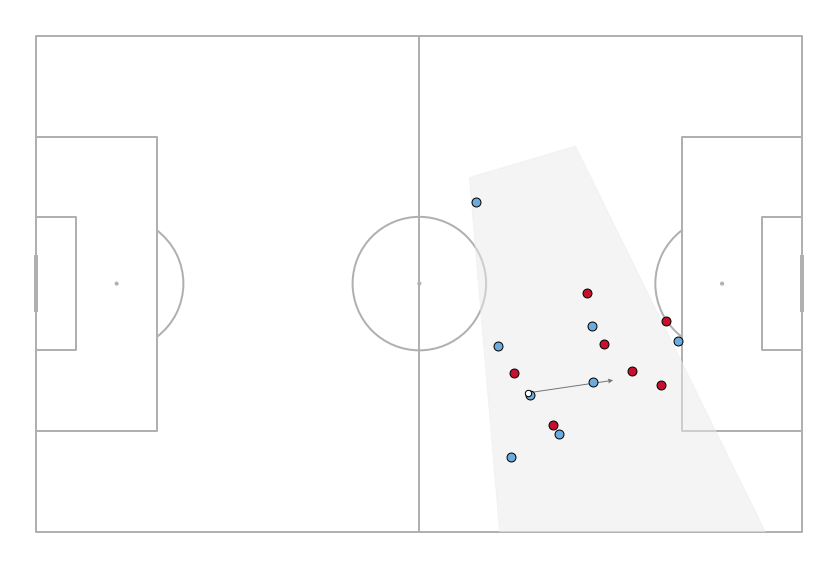

In [140]:
from unxpass.visualization import plot_action
plot_action(df_actions.reset_index().loc[2172])

In [10]:
df_actions = pd.DataFrame()

for i in tqdm.tqdm(range(len(games))):
    game_id = games.loc[i,"game_id"]
    action = add_names(db.actions(game_id)).reset_index()
    df_actions = pd.concat([df_actions,action],axis=0)

100%|██████████| 146/146 [00:19<00:00,  7.47it/s]


In [11]:
df_actions = df_actions.reset_index().drop(columns=['index'])

In [12]:
df_actions['type_name'].value_counts()

pass                135327
dribble             127977
clearance             6306
throw_in              5989
tackle                5187
take_on               4361
bad_touch             4048
interception          3920
foul                  3795
shot                  3438
cross                 3111
freekick_short        2332
goalkick              2244
freekick_crossed      1329
corner_crossed        1080
keeper_save            783
keeper_claim           483
corner_short           252
keeper_punch           207
shot_penalty           129
shot_freekick           97
Name: type_name, dtype: int64

In [13]:
df_actions.shape

(312395, 24)

#### pass=135,327 + cross=3,111개이지만
#### 발로 수행한 패스 & 360보이는걸 줄이면 50000개정도밖에 안 남음

In [14]:
df_actions[df_actions['type_name'] == 'pass']['bodypart_name'].value_counts()

foot_right    85772
foot_left     39219
head           5026
foot           3387
other          1923
Name: bodypart_name, dtype: int64

In [15]:
#we discard passes for which the origin or destination location falls outside the 360 snapshot
df_actions[df_actions['type_name'] == 'pass']['in_visible_area_360'].value_counts()

0    80125
1    55202
Name: in_visible_area_360, dtype: int64

## Select passes

We only use passes that are 
- performed by foot
- part of open play
- for which the start and end location are included in the 360 snapshot

In [16]:
passes_idx = PassesDataset.actionfilter(df_actions)
df_actions.loc[passes_idx].head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3857256,0,4acb4fd2-f46a-4d73-993c-e06597873924,1,0.0,773,5545,52.058824,33.655696,67.852941,36.754430,5,0,1,773.0,From Kick Off,0,"{'pass': {'recipient': {'id': 6983, 'name': 'R...","[[16.46325036488545, 0.0], [39.12275373649869,...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
33,3857256,33,77506bf9-02f7-43b8-9f3f-ad6c07b5ffc5,1,72.0,773,16026,62.470588,45.275949,47.647059,13.255696,4,0,1,773.0,Regular Play,0,"{'pass': {'recipient': {'id': 30401, 'name': '...","[[20.805892202379724, 0.0], [37.13185058143601...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_left
39,3857256,39,b00a80aa-8b29-4999-9b24-925bc740c48a,1,84.0,786,6687,7.323529,11.792405,20.117647,27.027848,4,0,1,786.0,Regular Play,0,"{'pass': {'recipient': {'id': 5589, 'name': 'S...","[[8.959396489971112, 0.0], [0.0, 9.39304661502...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_left
40,3857256,40,8c034f73-5886-4415-9f08-f034bd549b1a,1,87.0,786,5589,20.470588,27.027848,33.529412,27.027848,0,0,0,786.0,Regular Play,1,"{'pass': {'length': 14.8, 'angle': 0.0, 'heigh...","[[16.502956969793438, 0.0], [0.0, 20.073650809...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,fail,foot
46,3857256,46,fa2e2a47-00cf-4b9f-a015-3d5973cfc6e3,1,107.0,786,27719,40.147059,64.643038,30.176471,50.182278,4,0,1,786.0,From Throw In,0,"{'pass': {'recipient': {'id': 6321, 'name': 'M...","[[37.604559663784755, 12.735193281145406], [20...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_left


In [17]:
df_actions.loc[passes_idx]['type_name'].value_counts()

pass     52394
cross     1064
Name: type_name, dtype: int64

## Compute features and labels

The `unxpass.features` and `unxpass.labels` modules implement various feature generation and labeling functions, respectively.

In [8]:
from unxpass import features as fs
from unxpass import labels as ls

# List of available features
print("Features:", [f.__name__ for f in fs.all_features])

# List of available labels
print("Labels:", [f.__name__ for f in ls.all_labels])

Features: ['intended_endlocation', 'intended_endpolar', 'intended_relative_endlocation', 'intended_movement', 'intended_angle', 'actiontype', 'actiontype_onehot', 'result', 'result_onehot', 'actiontype_result_onehot', 'bodypart', 'bodypart_onehot', 'time', 'startlocation', 'relative_startlocation', 'endlocation', 'relative_endlocation', 'startpolar', 'endpolar', 'movement', 'team', 'time_delta', 'space_delta', 'goalscore', 'angle', 'under_pressure', 'packing_rate', 'ball_height', 'ball_height_onehot', 'player_possession_time', 'speed', 'nb_opp_in_path', 'dist_defender', 'freeze_frame_360', 'defenders_in_3m_radius', 'defenders_in_5m_radius']
Labels: ['scores', 'scores_xg', 'concedes', 'concedes_xg', 'success']


In [9]:
[f.__name__ for f in fs.all_features][:30]

['intended_endlocation',
 'intended_endpolar',
 'intended_relative_endlocation',
 'intended_movement',
 'intended_angle',
 'actiontype',
 'actiontype_onehot',
 'result',
 'result_onehot',
 'actiontype_result_onehot',
 'bodypart',
 'bodypart_onehot',
 'time',
 'startlocation',
 'relative_startlocation',
 'endlocation',
 'relative_endlocation',
 'startpolar',
 'endpolar',
 'movement',
 'team',
 'time_delta',
 'space_delta',
 'goalscore',
 'angle',
 'under_pressure',
 'packing_rate',
 'ball_height',
 'ball_height_onehot',
 'player_possession_time']

In [7]:
[f.__name__ for f in fs.all_features][30:]

['speed',
 'nb_opp_in_path',
 'dist_defender',
 'freeze_frame_360',
 'defenders_in_3m_radius',
 'defenders_in_5m_radius']

As some of these functions require data of the entire game (e.g., to determine the current scoreline) they should always be applied on the game state representation of the full game. Relevant actions can be selected afterwards.

### 해당 함수(left_to_right)는 어떻게 전처리하려고 하지 않은거지?

In [29]:
from socceraction.vaep.features import gamestates as to_gamestates
from unxpass.utils import play_left_to_right

# convert actions to gamestates
home_team_id, _ = test_db.get_home_away_team_id(game_id)
gamestates = play_left_to_right(to_gamestates(df_actions, nb_prev_actions=3), home_team_id)

In [52]:
# compute features and labels
pd.concat([
    fs.angle(gamestates),
    ls.success(df_actions)
], axis=1)

angle_a0  angle_a1  angle_a2  success
game_id action_id                                       
3869254 0          3.688406  3.688406  3.688406     True
        1          4.510174  3.688406  3.688406     True
        2          0.560789  4.510174  3.688406    False
        3         -0.373984  3.702382  1.368581     True
        4         -0.292179  2.767609  0.560789    False
...                     ...       ...       ...      ...
        2018       0.000000  3.558962 -1.258499     True
        2019      -0.460357  0.000000  3.558962     True
        2020       0.424211 -0.460357  0.000000     True
        2021       0.000000  3.565804  2.681236     True
        2022       0.000000  0.000000  0.424211     True

[2023 rows x 4 columns]

In [53]:
# compute features and labels
pd.concat([
    fs.intended_angle(gamestates),
    ls.success(df_actions)
], axis=1)

angle_a0  angle_a1  angle_a2  success
game_id action_id                                       
3869254 0          3.688406  3.688406  3.688406     True
        1          4.510174  3.688406  3.688406     True
        2          0.560789  4.510174  3.688406    False
        3         -0.373984  3.702382  1.368581     True
        4         -0.292179  2.767609  0.560789    False
...                     ...       ...       ...      ...
        2018       0.000000  3.558962 -1.258499     True
        2019      -0.460357  0.000000  3.558962     True
        2020       0.424211 -0.460357  0.000000     True
        2021       0.000000  3.565804  2.681236     True
        2022       0.000000  0.000000  0.424211     True

[2023 rows x 4 columns]

In [41]:
# or, as a shorthand to the above
pd.concat([
    fs.get_features(test_db, game_id, xfns=[fs.relative_endlocation,], actionfilter=PassesDataset.actionfilter),
    ls.get_labels(test_db, game_id, yfns=[ls.success], actionfilter=PassesDataset.actionfilter)
], axis=1)

end_dist_sideline_a0  end_dist_goalline_a0  \
game_id action_id                                               
3869254 0                     21.002532             75.000000   
        2                     22.810127             35.294118   
        7                     11.448101             45.352941   
        8                     18.506329             44.558824   
        10                    12.308861             44.911765   
...                                 ...                   ...   
        1978                   7.574684             36.352941   
        1980                  13.255696             16.588235   
        2003                   9.296203             50.029412   
        2005                   0.086076             47.117647   
        2014                  16.698734              7.588235   

                   end_dist_sideline_a1  end_dist_goalline_a1  \
game_id action_id                                               
3869254 0                     21.002532             75.000000   
        2                     20.141772             75.176471   
        7                      4.906329             68.647059   
        8                     11.448101             45.352941   
        10                    18.248101             44.558824   
...                                 ...                   ...   
        1978                   0.172152             40.147059   
        1980                   9.984810             34.676471   
        2003                  11.017722             46.588235   
        2005                   2.926582             44.205882   
        2014                  11.017722             10.588235   

                   end_dist_sideline_a2  end_dist_goalline_a2  success  
game_id action_id                                                       
3869254 0                     21.002532             75.000000     True  
        2                     21.002532             75.000000    False  
        7                     11.362025             70.323529     True  
        8                      4.906329             68.647059     True  
        10                    18.506329             44.558824     True  
...                                 ...                   ...      ...  
        1978                   0.000000             51.352941     True  
        1980                   7.574684             36.352941     True  
        2003                   2.237975             61.235294    False  
        2005                   9.296203             50.029412    False  
        2014                   8.005063             11.911765    False  

[353 rows x 7 columns]

In [42]:
# or, as a shorthand to the above
pd.concat([
    fs.get_features(test_db, game_id, xfns=[fs.intended_relative_endlocation], actionfilter=PassesDataset.actionfilter),
    ls.get_labels(test_db, game_id, yfns=[ls.success], actionfilter=PassesDataset.actionfilter)
], axis=1)

end_dist_sideline_a0  end_dist_goalline_a0  \
game_id action_id                                               
3869254 0                     21.002532             75.000000   
        2                     22.810127             35.294118   
        7                     11.448101             45.352941   
        8                     18.506329             44.558824   
        10                    12.308861             44.911765   
...                                 ...                   ...   
        1978                   7.574684             36.352941   
        1980                  13.255696             16.588235   
        2003                   9.296203             50.029412   
        2005                   0.086076             47.117647   
        2014                  16.698734              7.588235   

                   end_dist_sideline_a1  end_dist_goalline_a1  \
game_id action_id                                               
3869254 0                     21.002532             75.000000   
        2                     20.141772             75.176471   
        7                      4.906329             68.647059   
        8                     11.448101             45.352941   
        10                    18.248101             44.558824   
...                                 ...                   ...   
        1978                   0.172152             40.147059   
        1980                   9.984810             34.676471   
        2003                  11.017722             46.588235   
        2005                   2.926582             44.205882   
        2014                  11.017722             10.588235   

                   end_dist_sideline_a2  end_dist_goalline_a2  success  
game_id action_id                                                       
3869254 0                     21.002532             75.000000     True  
        2                     21.002532             75.000000    False  
        7                     11.362025             70.323529     True  
        8                      4.906329             68.647059     True  
        10                    18.506329             44.558824     True  
...                                 ...                   ...      ...  
        1978                   0.000000             51.352941     True  
        1980                   7.574684             36.352941     True  
        2003                   2.237975             61.235294    False  
        2005                   9.296203             50.029412    False  
        2014                   8.005063             11.911765    False  

[353 rows x 7 columns]

## The "PassesDataset" interface

To make things easier, we provide an interface that does all of the above. Additionally, it can store all computed features and labels locally. This is recommended when experimenting with multiple model configurations. It also functions as a PyTorch dataset.

In [13]:
from pathlib import Path
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset

test_DB_PATH = Path("../stores/test-database.sqlite")
test_db = SQLiteDatabase(test_DB_PATH)

In [14]:
STORES_FP = Path("../stores")

test_dataset = PassesDataset(
    path=STORES_FP / "datasets" / "default" / "test",
    xfns= ['intended_endlocation'],
    yfns= ['success']   
)


[08/06/23 20:31:58] ERROR    No complete dataset found at ../stores/datasets/default/test. Run      ]8;id=329437;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=94451;file:///home/toc3/anaconda3/lib/python3.7/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\
                             'create' to create it.                                                                

In [15]:
test_dataset.create(test_db)

Output()

/home/toc3/un-xPass/unxpass/features.py:129: RuntimeWarning: invalid value encountered in true_divide
  np.sum(a * b, axis=1) / (np.linalg.norm(a) * np.linalg.norm(b, axis=1)), -1, 1

Output()

In [71]:
DATA_DIR = Path("../stores/")

dataset = PassesDataset(
    path=DATA_DIR / "datasets" / "default" / "train",
)

#unxpass / datasets.py의 create함수에서 db생성시 자동으로 전처리 되는 과정
dataset.create(db)

TypeError: __init__() missing 2 required positional arguments: 'xfns' and 'yfns'

You can now retrieve the computed features and labels as a Pandas DataFrame.

In [53]:
db.games

<bound method SQLiteDatabase.games of <unxpass.databases.sqlite.SQLiteDatabase object at 0x7f79281fa150>>

In [ ]:
db.close()